In [41]:
!python -m pip install -qq kaggle

In [42]:
%%bash
mkdir ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
kaggle datasets download paultimothymooney/kermany2018
unzip -qq "/content/kermany2018.zip"
rm -rf  "/content/oct2017"                                                      # delete recursive data
mv "OCT2017 " "dataset"                                                            # rename main directory as data
mv "dataset/val" "dataset/valid"                                                      # rename val to valid
rm -rf "sample_data"

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100%|██████████| 10.8G/10.8G [01:43<00:00, 112MB/s]


In [43]:
#@title Default title text
import os
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf                                                         # load tensorflow
import tensorflow_datasets as tfds                                              # tensorflow datasets

In [44]:
for setType in ['dataset/train','dataset/test','dataset/valid']:
  classes=os.listdir(setType)                                                   # get all classes names
  print('Total classes:',len(classes))                                          # total classes
  print('Class names:',classes)                                                 # class names
  # clean class names
  classes_clean=[re.sub('[^A-Za-z0-9 ]',' ',class_) for class_ in classes]      # remove unwanted characters
  classes_clean=[re.sub('[ ]+','_',class_).casefold() for class_ in classes_clean]# replace one or multiple spaces by underscore '_'
  print('Cleaned Class names:',classes_clean)                                   # clean class names
  # rename class names with clean class names
  for old_name,new_name in zip(classes,classes_clean):                          # get old and new class names
    os.rename(os.path.join(setType,old_name),os.path.join(setType,new_name))# rename with new class names
  # get minimum class count ------------------------------------------------------
  class_counts:dict=dict()                                                      # get class samples for each class
  # get number of files in each class
  for class_ in os.listdir(setType):                                            # get class name folder
    class_counts[class_]=len(os.listdir(os.path.join(setType,class_)))          # count samples in given class
  print('Class counts:',class_counts)                                           # print class counts
assert os.listdir('dataset/train')==os.listdir('dataset/test')==os.listdir('dataset/valid'),'Different classes found in train and test'# check classes
training_classes=os.listdir('dataset/train')                                    # make list of training classes

Total classes: 4
Class names: ['CNV', 'DRUSEN', 'NORMAL', 'DME']
Cleaned Class names: ['cnv', 'drusen', 'normal', 'dme']
Class counts: {'dme': 11348, 'drusen': 8616, 'normal': 26315, 'cnv': 37205}
Total classes: 4
Class names: ['CNV', 'DRUSEN', 'NORMAL', 'DME']
Cleaned Class names: ['cnv', 'drusen', 'normal', 'dme']
Class counts: {'dme': 242, 'drusen': 242, 'normal': 242, 'cnv': 242}
Total classes: 4
Class names: ['CNV', 'DRUSEN', 'NORMAL', 'DME']
Cleaned Class names: ['cnv', 'drusen', 'normal', 'dme']
Class counts: {'dme': 8, 'drusen': 8, 'normal': 8, 'cnv': 8}


In [45]:
# load dataset - train, test and valid
train=tf.keras.utils.image_dataset_from_directory('dataset/train',labels='inferred',label_mode='int',class_names=None,color_mode='rgb',
                                                  batch_size=32,image_size=(256,256),shuffle=True,validation_split=0.0,
                                                  interpolation='bilinear',subset=None,)
test=tf.keras.utils.image_dataset_from_directory('dataset/test',labels='inferred',label_mode='int',class_names=None,color_mode='rgb',
                                                 batch_size=32,image_size=(256,256),shuffle=False,validation_split=0.0,
                                                 interpolation='bilinear',subset=None,seed=8,)
valid=tf.keras.utils.image_dataset_from_directory('dataset/valid',labels='inferred',label_mode='int',class_names=None,color_mode='rgb',
                                                  batch_size=128,image_size=(256,256),shuffle=True,validation_split=0.3,
                                                  interpolation='bilinear',subset='validation',seed=8,)
print('Total validation images:',test.cardinality()*32)
print('Total test images:',test.cardinality()*32)
training_classes:list=train.class_names
test_classes:list=test.class_names
valid_classes:list=valid.class_names
assert training_classes==test_classes,'class count in train and test set is not same'
print('Class names:',training_classes)

Found 83484 files belonging to 4 classes.
Found 968 files belonging to 4 classes.
Found 32 files belonging to 4 classes.
Using 9 files for validation.
Total validation images: tf.Tensor(992, shape=(), dtype=int64)
Total test images: tf.Tensor(992, shape=(), dtype=int64)
Class names: ['cnv', 'dme', 'drusen', 'normal']


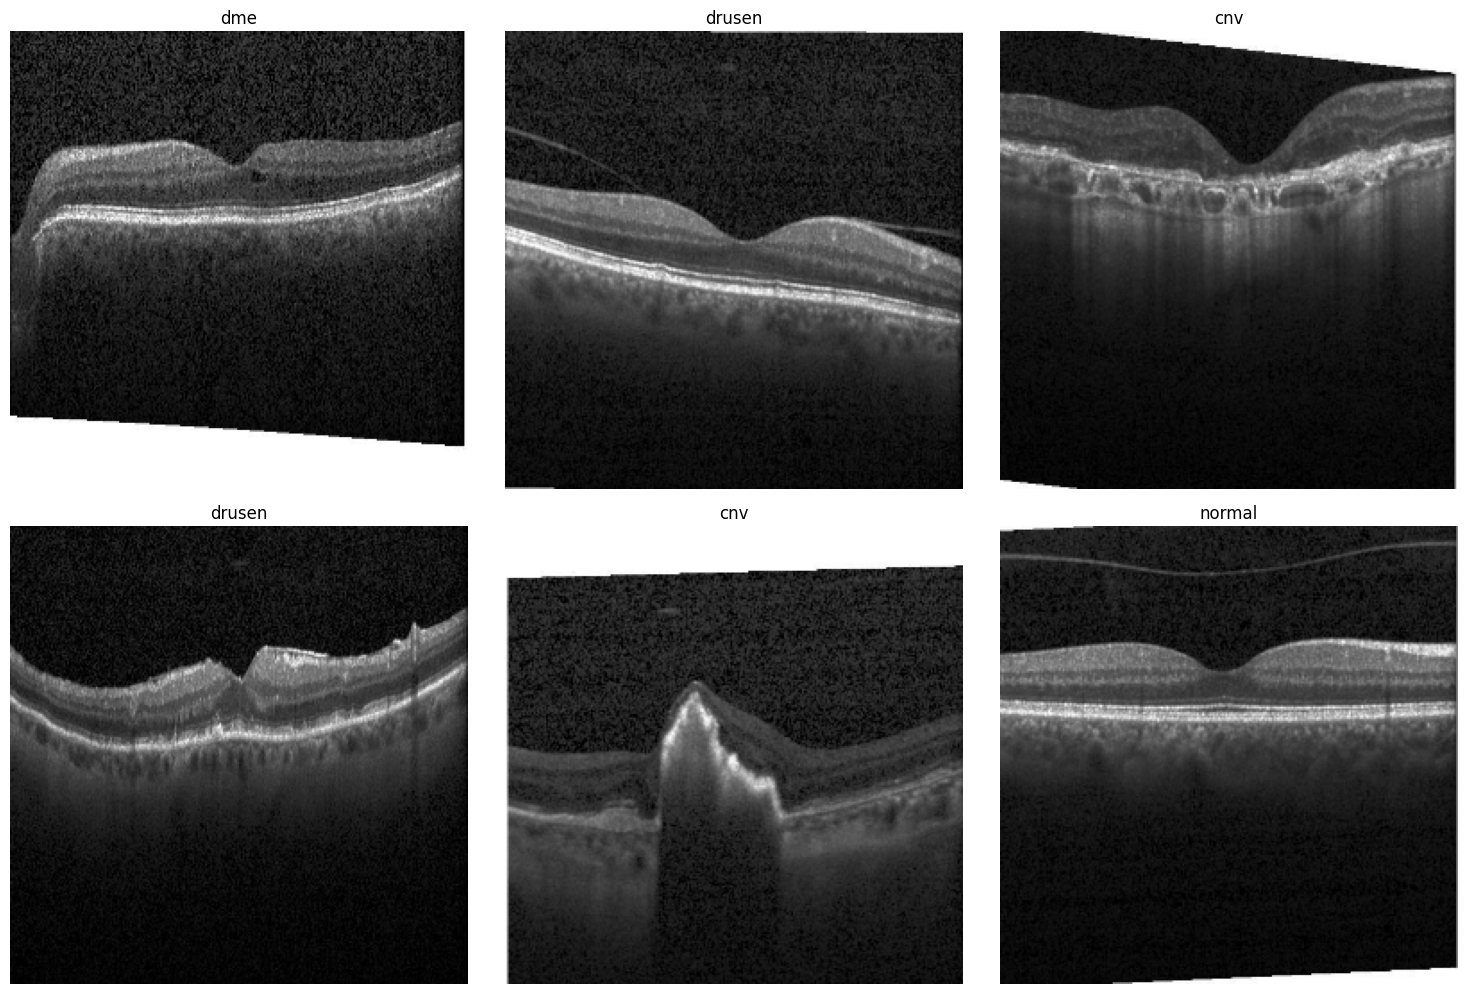

In [46]:
# make plot data training data
for images,labels in train.take(1):break                                        # get a batch of data
images_to_plot:int=6                                                            # number of images to plot
plt.figure(figsize=(15,15))                                                     # figure size
for index in range(images_to_plot):                                             # loop over image index
  plt.subplot(3,3,index+1)                                                      # subplot rows = 3, columns = 3
  plt.imshow(images[index].numpy().astype('uint8'))                             # make plot image
  plt.axis('off')                                                               # make axis off
  plt.title(training_classes[labels[index].numpy()])                            # make add labels as class names
plt.tight_layout()                                                              # adjust layout space
plt.show()                                                                      # make plot show

In [47]:
print('Maximum pixel values:',tf.reduce_max(images))                            # maximum pixel values in inputs
print('Minimum pixel values:',tf.reduce_min(images))                            # minimum pixel values in inputs
print('Object type of inputs (X):',type(images))                                # input types
print('Data type in inputs (X):',images.dtype)                                  # data type in inputs
print('Object type of outputs (y):',type(labels))                               # output types
print('Data type in outputs (X):',labels.dtype)                                 # data type in outputs

Maximum pixel values: tf.Tensor(255.0, shape=(), dtype=float32)
Minimum pixel values: tf.Tensor(0.0, shape=(), dtype=float32)
Object type of inputs (X): <class 'tensorflow.python.framework.ops.EagerTensor'>
Data type in inputs (X): <dtype: 'float32'>
Object type of outputs (y): <class 'tensorflow.python.framework.ops.EagerTensor'>
Data type in outputs (X): <dtype: 'int32'>


In [48]:
base_model=tf.keras.applications.VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3))  # laod base model - VGG16
#base_model.summary(line_length=120,positions=None,print_fn=None,expand_nested=True,show_trainable=False,layer_range=None)# print base model summary
base_model.trainable=False                                                                            # make freeze base

In [49]:
inputs=tf.keras.layers.Input(shape=(224,224,3),batch_size=None,name='model_inputs')                                 # add input layer
model_x=tf.keras.layers.Rescaling(1/255,offset=0.0,name='rescaler')(inputs)                                         # rescale inputs
model_x=base_model(model_x)                                                                                         # feed inputs to base model
model_x=tf.keras.layers.Flatten(name='flatten')(model_x)                                                            # make flatten outputs
model_x=tf.keras.layers.Dense(1024,activation='relu')(model_x)                                                      # apply dense layer
outputs=tf.keras.layers.Dense(len(training_classes),activation='softmax')(model_x)                                  # output layer
model=tf.keras.Model(inputs=[inputs],outputs=[outputs],name='custom_vgg16')                                         # build model
model.summary(line_length=120,positions=None,print_fn=None,expand_nested=True,show_trainable=True,layer_range=None) # print model summary

Model: "custom_vgg16"
___________________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           Trainable  
 model_inputs (InputLayer)                            [(None, 224, 224, 3)]                           0                 Y          
                                                                                                                                   
 rescaler (Rescaling)                                 (None, 224, 224, 3)                             0                 Y          
                                                                                                                                   
 vgg16 (Functional)                                   (None, 7, 7, 512)                               14714688          N          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

In [50]:
random_flip=tf.keras.layers.RandomFlip('horizontal_and_vertical',name='random_flip')                      # random flip layer
random_zoom=tf.keras.layers.RandomZoom(height_factor=0.1,width_factor=0.1,name='random_zoom')             # random zoom layer
random_rotate=tf.keras.layers.RandomRotation(0.3,name='random_rotate')                                    # random rotate layers
random_brightness=tf.keras.layers.RandomBrightness(0.3,value_range=(0.0,255.0),name='random_brightness')  # random brightness layer
augmentations=[random_flip,random_zoom,random_rotate,random_brightness]                                   # make list of data augmentation
resizer=tf.keras.layers.Resizing(224,224,interpolation='nearest',name='rescaler')
# make apply augmentation on training data
for augmentation in augmentations:
  train.map(lambda images,labels: (augmentation(images),labels))                                          # make apply augmentation
train=train.map(lambda images,labels: (resizer(images),labels))
valid=valid.map(lambda images,labels: (resizer(images),labels))
test=test.map(lambda images,labels: (resizer(images),labels))

In [51]:
# make compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [60]:
# make early stopping
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy',min_delta=0,patience=3,verbose=1,mode='auto',restore_best_weights=True)
1+2
# make train model
history=model.fit(train,batch_size=32,epochs=10_000,verbose=2,callbacks=[early_stop],validation_split=0,validation_data=test,shuffle=True)

Epoch 1/10000
2609/2609 - 435s - loss: 0.1456 - sparse_categorical_accuracy: 0.9478 - val_loss: 0.1809 - val_sparse_categorical_accuracy: 0.9504 - 435s/epoch - 167ms/step
Epoch 2/10000
2609/2609 - 420s - loss: 0.1359 - sparse_categorical_accuracy: 0.9509 - val_loss: 0.1724 - val_sparse_categorical_accuracy: 0.9370 - 420s/epoch - 161ms/step
Epoch 3/10000
2609/2609 - 419s - loss: 0.1225 - sparse_categorical_accuracy: 0.9559 - val_loss: 0.1163 - val_sparse_categorical_accuracy: 0.9680 - 419s/epoch - 161ms/step
Epoch 4/10000
2609/2609 - 420s - loss: 0.1171 - sparse_categorical_accuracy: 0.9576 - val_loss: 0.2504 - val_sparse_categorical_accuracy: 0.9236 - 420s/epoch - 161ms/step
Epoch 5/10000
2609/2609 - 415s - loss: 0.1117 - sparse_categorical_accuracy: 0.9582 - val_loss: 0.1633 - val_sparse_categorical_accuracy: 0.9587 - 415s/epoch - 159ms/step
Epoch 6/10000


KeyboardInterrupt: ignored

In [53]:
# see model history (first five epoches)
pd.DataFrame(history.history).head()

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
0,0.437396,0.857949,0.235865,0.893595
1,0.281911,0.898591,0.231794,0.910124
2,0.247036,0.911193,0.127062,0.958678
3,0.222402,0.919685,0.259967,0.893595
4,0.201136,0.927351,0.184171,0.935950


In [54]:
# see model history (last five epoches)
pd.DataFrame(history.history).tail()

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
13,0.104962,0.961562,0.134052,0.966942
14,0.097458,0.964556,0.153029,0.964876
15,0.091385,0.966437,0.150020,0.963843
16,0.091414,0.966065,0.179421,0.953512
17,0.082428,0.969910,0.159899,0.966942


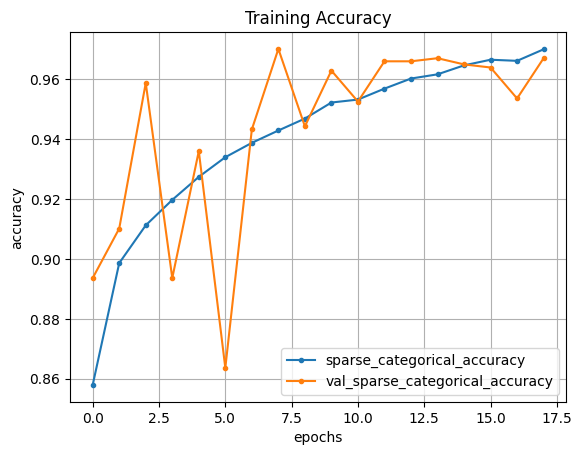

In [55]:
# make plot training accuracy and validation accuracy
pd.DataFrame(history.history)[['sparse_categorical_accuracy','val_sparse_categorical_accuracy']].plot(marker='.')# make plot
plt.grid(),plt.title('Training Accuracy'),plt.xlabel('epochs'),plt.ylabel('accuracy')# add grid, title and axis labels
plt.show()                                                                      # make plot show

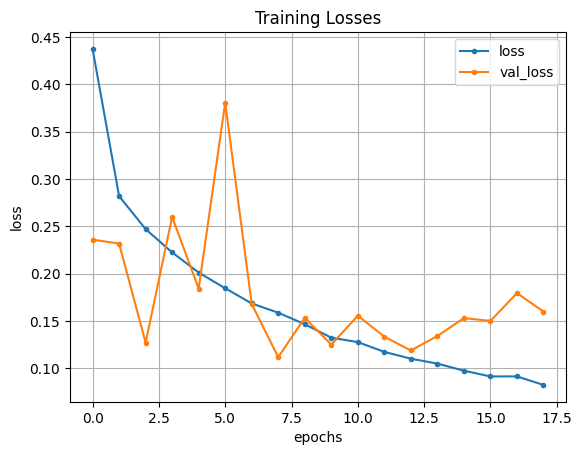

In [56]:
# make plot training losses and validation losses
pd.DataFrame(history.history)[['loss','val_loss']].plot(marker='.')             # make plot
plt.grid(),plt.title('Training Losses'),plt.xlabel('epochs'),plt.ylabel('loss') # add grid, title and axis labels
plt.show()                                                                      # make plot show

In [57]:
# evaluate model
results=model.evaluate(test,batch_size=None,verbose="auto",sample_weight=None,return_dict=True)
print('Testing results:',results)                                               # make print results

31/31 [==============================] - 4s 129ms/step - loss: 0.1117 - sparse_categorical_accuracy: 0.9700
Testing results: {'loss': 0.11172795295715332, 'sparse_categorical_accuracy': 0.9700413346290588}


In [58]:
# make save model (weights and configuration)
model.save('eye_disease',overwrite=True,save_format=None)               # make save

In [59]:
!zip -r -qq "eye_disease.zip" "eye_disease"                     # make zip model
# make auto download model weights
from google.colab import files                                                  # load file class
files.download('eye_disease.zip')                                       # download model zip file

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [62]:
%cp "/content/eye_disease.zip" "/content/drive/MyDrive/output"